In [ ]:
import os

os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [ ]:
!pip install replay-rec --quiet
!pip install rs_datasets
!pip install implicit

In [1]:
import hnswlib
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
import time

from implicit.cpu.als import AlternatingLeastSquares
from rs_datasets import MovieLens
from replay.preprocessing.filters import MinCountFilter, LowRatingFilter
from replay.metrics import HitRate, NDCG, Coverage, Recall, Experiment
from replay.splitters.time_splitter import TimeSplitter
import time
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.precision", 6)

# Использование приближенного поиска для построения рекомендаций

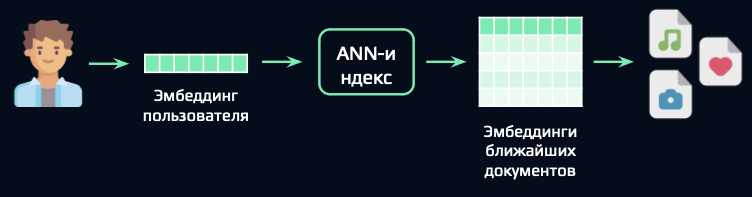

In [2]:
USER_COL = "user_id"
ITEM_COL = "item_id"
RATING_COL = "rating"
TIMESTAMP = "timestamp"
K = 10
SEED = 123
DIM = 16

## Загрузка датасета Movielens 20m

In [3]:
ml = MovieLens("20m")
ratings, items = ml.ratings, ml.items

In [4]:
ratings = MinCountFilter(num_entries=20).transform(ratings)

In [5]:
print(f"Количество уникальных пользователей: {ratings[USER_COL].nunique()}")
print(f"Количество уникальных фильмов: {ratings[ITEM_COL].nunique()}")

Количество уникальных пользователей: 138493
Количество уникальных фильмов: 26744


In [6]:
ratings[TIMESTAMP] = pd.to_datetime(ratings[TIMESTAMP], unit="s")

Переведем рейтинги в float формат для корректной работы моделей.

In [7]:
ratings[RATING_COL] = ratings[RATING_COL].astype(float)

## Разбиение данных

In [8]:
train, test = TimeSplitter(
    time_threshold=0.2,
    drop_cold_users=True,
    drop_cold_items=True,
    query_column=USER_COL,
).split(ratings)

## Кодирование id пользователей и айтемов

In [9]:
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()
user_encoder.fit(train[USER_COL])
item_encoder.fit(train[ITEM_COL])

LabelEncoder()

In [10]:
items = items[items[ITEM_COL].isin(train[ITEM_COL].unique())]

train.loc[:, USER_COL] = user_encoder.transform(train[USER_COL])
train.loc[:, ITEM_COL] = item_encoder.transform(train[ITEM_COL])

test.loc[:, USER_COL] = user_encoder.transform(test[USER_COL])
test.loc[:, ITEM_COL] = item_encoder.transform(test[ITEM_COL])

items.loc[:, ITEM_COL] = item_encoder.transform(items[ITEM_COL])

## Фильтрация

Будем оценивать качество на фильмах с оценкой не менее 4 и на пользователях из train

In [11]:
test = LowRatingFilter(value=4).transform(test)

## Обучение модели ALS

In [12]:
test_users = test[[USER_COL]].drop_duplicates().reset_index(drop=True)
test_users.head(2)

,user_id
0,4983
1,102141


In [13]:
# Преобразование DataFrame в разреженную матрицу формата CSR
csr_train = csr_matrix(
    (train[RATING_COL].astype(float), (train[USER_COL], train[ITEM_COL]))
)

In [14]:
# Обучение ALS
# model = AlternatingLeastSquares(factors=DIM, regularization=0.01, iterations=20)
# model.fit(csr_train)

Сохранение

In [15]:
# with open("model_als.pkl", "wb") as f:
#     pickle.dump(model, f)

Загрузка

In [16]:
model = AlternatingLeastSquares(factors=DIM, regularization=0.01, iterations=20)

with open("/content/model_als.pkl", "rb") as f:
    model = pickle.load(f)

In [17]:
ids, scores = model.recommend(
    test_users[USER_COL].values,
    csr_train[test_users[USER_COL].values],
    N=K,
    filter_already_liked_items=False,
)

In [18]:
def prepare_recs(test_users, rec_item_ids, rec_relevances):
    predict = test_users.copy()
    predict[ITEM_COL] = rec_item_ids.tolist()
    predict[RATING_COL] = rec_relevances.tolist()
    predict = predict.explode(column=[ITEM_COL, RATING_COL]).reset_index(drop=True)
    predict[ITEM_COL] = predict[ITEM_COL].astype(int)
    predict[RATING_COL] = predict[RATING_COL].astype("double")
    return predict

In [19]:
als_predict = prepare_recs(test_users, rec_item_ids=ids, rec_relevances=scores)


## Подсчет метрик

In [20]:
metrics = Experiment(
    [NDCG(K), HitRate(K), Coverage(K)],
    test,
    train,
    query_column=USER_COL,
    item_column=ITEM_COL,
)

In [21]:
metrics.add_result("ALS", als_predict)
metrics.results.sort_values("NDCG@10", ascending=False)

,NDCG@10,HitRate@10,Coverage@10
ALS,0.048424,0.246259,0.067404


## Персональные рекомендации как восстановление полной матрицы

Для ALS из библиотеки implicit у нас есть удобный и достаточно быстрый api для получения рекомендаций. Но есть множество других моделей, который также возвращают вектора пользователей и айтемов, близкие по косинусу/скалярному произведению. Допустим у нас есть такая модель, и попробуем построить рекомендации наивным способом.

In [22]:
start_time = time.time()

scores = model.user_factors[test_users[USER_COL].values] @ model.item_factors.T
ids = np.argpartition(scores, -K)[:, -K:]
scores = np.take_along_axis(scores, ids, axis=1)

time_query = time.time() - start_time
print(f"Время выполнения {round(time_query,4)}c")

Время выполнения 2.1251c


In [23]:
matrix_completion_predict = prepare_recs(
    test_users, rec_item_ids=ids, rec_relevances=scores
)

In [24]:
metrics.add_result("ALS matrix completion", matrix_completion_predict)
metrics.results.sort_values("NDCG@10", ascending=False)

,NDCG@10,HitRate@10,Coverage@10
ALS,0.048424,0.246259,0.067404
ALS matrix completion,0.048424,0.246259,0.067404


In [25]:
time_log = pd.DataFrame(
    {"HNSWIndex": ["ALS matrix completion"], "Build": [0], "Recommend": [time_query]}
)
time_log

,HNSWIndex,Build,Recommend
0,ALS matrix completion,0,2.125138


## Рекомендации с использованием ann (hnswlib)

### Гиперпараметры $HNSW$

В реальности датасеты для рексистем очень большие, и мы быстро успремся в ограничения либо по памяти, либо по времени, если будем делать предсказание наивно. Попробуем использовать методы приближенного поиска соседей.

Aлгоритм $HNSW$ основан на графовом подходе. На нулевом слое располагаются все N вершин из исходной выборки, на следующих слоях графа число вершин уменьшается.


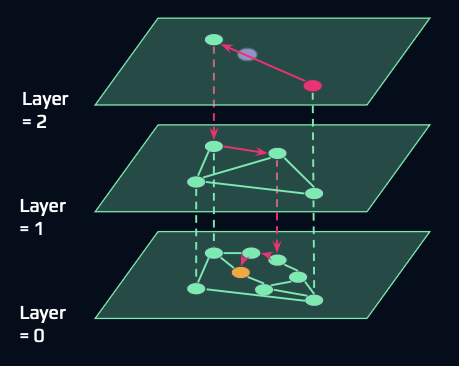

 **Основными гиперпараметрами алгоритма являются:**


$M$- количество ребер для каждой вершины. Увеличение параметра обеспечивает более точный поиск, но приводит так же к большим затратам по памяти. В зависимости от реализации может быть возможность дополнительно настраивать максимальное количество ребер для каждой вершины на нижнем слое.

$ef\_construction$ — число соседей, рассматриваемых при добавлении новой вершины во время построения индекса. При более высоких значениях ef_construction растет точность поиска, однако это приводит к увеличению времени построения индекса.

$ef$ - число соседей, рассматриваемых во время поиска ближайших. Более высокие значения ef приводят к улучшению качества поиска, но так же увеличивают затраты по времени.

### Построение индекса

В качестве меры релевантности в ALS используется **скалярное произведение**. В hnswlib реализовано inner product space, для которого расстояние определяется как:
$$ d = 1 - \langle a, b \rangle$$

Нас интересует близость, т.е. само **скалярное произведение**, поэтому мы будем выполнять обратную трансформацию скоров после их извлечения из индекса $(1-scores)$.

In [26]:
# Обьявление индекса
p = hnswlib.Index(space="ip", dim=DIM)
p.init_index(max_elements=train.item_id.nunique(), ef_construction=50, M=5)
index_name = f"ANN M={p.M}, ef={p.ef}, ef_construction={p.ef_construction}"

In [27]:
start_time = time.time()
# Добавление каталога айтемов в индекс
p.add_items(model.item_factors)
time_add = time.time() - start_time
print(f"Время выполнения {round(time_add, 4)} c")

Время выполнения 0.2738 c


In [28]:
# Значение гиперпараметра ef
p.ef

10

### Предсказание с помощью индекса

In [29]:
start_time = time.time()
# Получение ближайших айтемов для каждого пользователя
ids, scores = p.knn_query(model.user_factors[test_users[USER_COL].values], K)
time_query = time.time() - start_time
print(f"Время выполнения {round(time_query,4)} c")

Время выполнения 0.0319 c


In [30]:
# Преобразование скоров обратно к формуле скалярного произведения
scores = 1 - scores

In [31]:
ann_predict = prepare_recs(test_users, rec_item_ids=ids, rec_relevances=scores)

In [32]:
new_time_log = {"HNSWIndex": index_name, "Build": time_add, "Recommend": time_query}

time_log.loc[len(time_log)] = new_time_log
time_log.sort_values("Recommend", ascending=False)

,HNSWIndex,Build,Recommend
0,ALS matrix completion,0.000000,2.125138
1,"ANN M=5, ef=10, ef_construction=50",0.273751,0.031862


### Оценка качества извлечения соседей

При использовании приближенного поиска нас интересует, какое количество реальных ближайших соседей (рекомендаций пользователя) мы нашли верно.  Поэтому для оценки качества приближенного поиска часто используется Recall. \

$$Recall@K(u) = \frac{|ApproxRecs@K_u \cap Recs@K_u|}{K}$$


$$Recall@K =\frac 1N  \sum_{u=1}^N Recall@K(u)$$


In [33]:
recall = Recall(topk=K, query_column=USER_COL)
recall_ann = recall(ann_predict, als_predict)["Recall@10"]

In [34]:
recall = Recall(topk=K, query_column=USER_COL)
recall_matrix_completion = recall(matrix_completion_predict, als_predict)["Recall@10"]

In [35]:
recall_matrix_completion

1.0

In [36]:
recall_data = pd.DataFrame({"Recall@10": [recall_matrix_completion, recall_ann]})

time_log = pd.concat([time_log, recall_data], axis=1).sort_values(
    "Recall@10", ascending=False
)
time_log

,HNSWIndex,Build,Recommend,Recall@10
0,ALS matrix completion,0.000000,2.125138,1.000000
1,"ANN M=5, ef=10, ef_construction=50",0.273751,0.031862,0.694033


### Оценка качества рекомендаций

In [37]:
metrics.add_result(index_name, ann_predict)
metrics.results.sort_values("NDCG@10", ascending=False)

,NDCG@10,HitRate@10,Coverage@10
"ANN M=5, ef=10, ef_construction=50",0.049121,0.244781,0.072732
ALS,0.048424,0.246259,0.067404
ALS matrix completion,0.048424,0.246259,0.067404


## Использование индекса для поиска похожих айтемов

Кроме построения рекомендаций для пользователей, мы можем искать с помощью индекса похожие фильмы

In [38]:
items[items[ITEM_COL] == 9704]

,item_id,title,genres
10600,9704,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX


In [39]:
ids, scores = p.knn_query(model.item_factors[[9704]], K)
scores = 1 - scores

In [40]:
scores_dict = dict(list(zip(ids.flatten().tolist(), scores.flatten().tolist())))
close_items = items[items[ITEM_COL].isin(ids.flatten())].copy()
close_items.loc[:, "score"] = close_items[ITEM_COL].map(scores_dict)

In [41]:
items[items[ITEM_COL] == 9704]

,item_id,title,genres
10600,9704,Harry Potter and the Goblet of Fire (2005),Adventure|Fantasy|Thriller|IMAX


In [42]:
close_items.sort_values("score", ascending=False)

,item_id,title,genres,score
7041,7041,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,0.024087
6429,6429,Pirates of the Caribbean: The Curse of the Bla...,Action|Adventure|Comedy|Fantasy,0.023157
8278,8262,"Incredibles, The (2004)",Action|Adventure|Animation|Children|Comedy,0.023042
10169,9430,Batman Begins (2005),Action|Crime|IMAX,0.022650
5853,5853,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,0.022579
6271,6271,Finding Nemo (2003),Adventure|Animation|Children|Comedy,0.022541
7953,7937,Spider-Man 2 (2004),Action|Adventure|Sci-Fi|IMAX,0.021212
7761,7750,Shrek 2 (2004),Adventure|Animation|Children|Comedy|Musical|Ro...,0.021178
10886,9871,V for Vendetta (2006),Action|Sci-Fi|Thriller|IMAX,0.020577
7249,7249,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,0.020559


Из документации: Note that inner product is not an actual metric. An element can be closer to some other element than to itself.

## Оценка влияния параметров индекса на точность и скорость

In [43]:
def make_index(ef, ef_construction, M, time_log, metrics):
    """Пайплайн времени работы, предсказания и качества ann.

    Args:
        ef (int): число соседей, рассматриваемых во время поиска.
        ef_construction (int): число соседей, рассматриваемых при добавлении новой вершины.
        M (int): количество ребер для каждой вершины.
        time_log (pd.DataFrame)
        metrics (replay.metrics)

    Returns:
        time_log, metrics
    """
    p = hnswlib.Index(space="ip", dim=DIM)
    p.init_index(
        max_elements=train.item_id.nunique(), ef_construction=ef_construction, M=M
    )
    p.ef = ef
    start_time = time.time()
    p.add_items(model.item_factors)
    time_add = time.time() - start_time

    start_time = time.time()
    ids, scores = p.knn_query(model.user_factors[test_users[USER_COL].values], K)
    time_query = time.time() - start_time
    ann_predict = prepare_recs(test_users, rec_item_ids=ids, rec_relevances=1 - scores)

    recall_metrics = recall(ann_predict, als_predict)["Recall@10"]
    index_name = f"ANN M={p.M}, ef={p.ef}, ef_construction={p.ef_construction}"
    time_log.loc[len(time_log)] = {
        "HNSWIndex": index_name,
        "Build": time_add,
        "Recommend": time_query,
        "Recall@10": recall_metrics,
    }

    metrics.add_result(index_name, ann_predict)
    metrics.results

    return time_log, metrics

In [44]:
parametrs_list = []
# Увеличиваем M при фиксированном ef_construction и ef по сравнению с базовым вариантом
parametrs_list.append({"M": 20, "ef": 10, "ef_construction": 50})

# Увеличиваем ef при фиксированном  M и ef_construction по сравнению с базовым вариантом
parametrs_list.append({"M": 5, "ef": 20, "ef_construction": 50})

# Увеличиваем ef_construction при фиксированном M и ef по сравнению с базовым вариантом
parametrs_list.append({"M": 5, "ef": 10, "ef_construction": 70})

In [45]:
for params in tqdm(parametrs_list):
    time_log, metrics = make_index(
        ef=params["ef"],
        ef_construction=params["ef_construction"],
        M=params["M"],
        time_log=time_log,
        metrics=metrics,
    )

  0%|          | 0/3 [00:00<?, ?it/s]

In [46]:
metrics.results.sort_values(["NDCG@10"]).sort_values("NDCG@10", ascending=False)

,NDCG@10,HitRate@10,Coverage@10
"ANN M=5, ef=10, ef_construction=50",0.049121,0.244781,0.072732
"ANN M=20, ef=10, ef_construction=50",0.048747,0.243303,0.074669
"ANN M=5, ef=20, ef_construction=50",0.048712,0.246813,0.069906
ALS,0.048424,0.246259,0.067404
ALS matrix completion,0.048424,0.246259,0.067404
"ANN M=5, ef=10, ef_construction=70",0.048357,0.241640,0.072167


In [47]:
time_log.sort_values("Recall@10", ascending=False)

,HNSWIndex,Build,Recommend,Recall@10
0,ALS matrix completion,0.000000,2.125138,1.000000
3,"ANN M=5, ef=20, ef_construction=50",0.294415,0.035644,0.806946
2,"ANN M=20, ef=10, ef_construction=50",0.398851,0.042495,0.787161
1,"ANN M=5, ef=10, ef_construction=50",0.273751,0.031862,0.694033
4,"ANN M=5, ef=10, ef_construction=70",0.729834,0.040650,0.693700
